# This notebook is intended to apply ML algorithms on IDS dataset for multiclass classification

##### Steps Followed
   1. Data Cleansing
   2. Feature selection
   3. Creation of Train/Test data
   4. Implementation of ML Algorithms
   5. Evalutaion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import accuracy_score

# import pickle
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split     # import module for train test split

## 1. Data Cleansing

In [2]:
path="../dataset/TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv"
t1=time.time()
df_tuesday=pd.read_csv(path)
t2=time.time()
print("time taken to read tuesday csv :: ", t2-t1, " seconds ")

/home/ebryx/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time taken to read tuesday csv ::  5.00166654586792  seconds 


##### ==>> Finding and dropping undefined / incorrect values in data frame

In [3]:
df_tuesday_dropped=df_tuesday.dropna( axis=0, how='any')

In [4]:
df_tuesday_dropped.replace(',,', np.nan, inplace=True)

/home/ebryx/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


<br>
We see that Fwd Header Length comes twice but with different anmes so first change name of Fwd Header Length.1 to Fwd Header Length and then remove it

In [5]:
df_tuesday_dup_rem = df_tuesday_dropped.loc[:,~df_tuesday_dropped.columns.duplicated()]
len(df_tuesday_dup_rem.columns)

85

In [6]:
df_tuesday_dropped.drop(columns=[' Fwd Header Length.1'], axis=1, inplace=True)

/home/ebryx/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
len(df_tuesday_dropped.columns)


84


##### ==>>convert categorical and string data to numerical data
Flow ID, Source IP, Destination IP, Timestamp, External IP <br>
using LabelEncoder of sklearn

In [8]:
from sklearn import preprocessing      # import required package for labelencoding
le=preprocessing.LabelEncoder()        # create a label encoder (category) object
le.fit(df_tuesday_dropped['Flow ID'])

LabelEncoder()

In [9]:
# labels
le.classes_
# Apply fitted encoder to the pandas column
le.transform(df_tuesday_dropped["Flow ID"])

array([152266, 152267, 152268, ..., 157091,  79335, 174989])

In [10]:
le_s_ip=preprocessing.LabelEncoder()
le_s_ip.fit(df_tuesday_dropped[' Source IP'])
le_s_ip.transform(df_tuesday_dropped[' Source IP'])

array([2145, 2145, 2145, ..., 2146, 5380, 2149])

In [11]:
le_d_ip=preprocessing.LabelEncoder()
le_d_ip.fit(df_tuesday_dropped[' Destination IP'])
le_d_ip.transform(df_tuesday_dropped[' Destination IP'])

array([2558, 2558, 2558, ..., 2558, 2556, 2558])

In [12]:
le_time_stamp=preprocessing.LabelEncoder()
le_time_stamp.fit(df_tuesday_dropped[' Timestamp'])
le_time_stamp.transform(df_tuesday_dropped[' Timestamp'])

array([422, 422, 422, ..., 439, 168,  38])

In [13]:
group=df_tuesday_dropped.groupby(' Label')
group.first()

Flow ID     Source IP   Source Port  \
 Label                                                                          
BENIGN       192.168.10.3-192.168.10.5-88-49182-6  192.168.10.5         49182   
FTP-Patator   172.16.0.1-192.168.10.50-45422-80-6    172.16.0.1         45422   
SSH-Patator   172.16.0.1-192.168.10.50-52358-22-6    172.16.0.1         52358   

             Destination IP   Destination Port   Protocol       Timestamp  \
 Label                                                                      
BENIGN         192.168.10.3                 88          6   4/7/2017 8:54   
FTP-Patator   192.168.10.50                 80          6  4/7/2017 10:30   
SSH-Patator   192.168.10.50                 22          6   4/7/2017 3:11   

              Flow Duration   Total Fwd Packets   Total Backward Packets  ...  \
 Label                                                                    ...   
BENIGN                  640                   7                        4  ...   
FTP-Patator         5216127                   3                        1  ...   
SSH-Patator             404                   2                        0  ...   

              act_data_pkt_fwd   min_seg_size_forward  Active Mean  \
 Label                                                               
BENIGN                       2                     20          0.0   
FTP-Patator                  0                     32          0.0   
SSH-Patator                  0                     32          0.0   

              Active Std   Active Max   Active Min  Idle Mean   Idle Std  \
 Label                                                                     
BENIGN               0.0          0.0          0.0        0.0        0.0   
FTP-Patator          0.0          0.0          0.0        0.0        0.0   
SSH-Patator          0.0          0.0          0.0        0.0        0.0   

              Idle Max   Idle Min  
 Label                             
BENIGN             0.0        0.0  
FTP-Patator        0.0        0.0  
SSH-Patator        0.0        0.0  

[3 rows x 83 columns]

In [14]:
df_tuesday_dropped[[' Flow Packets/s', 'Flow Bytes/s']].replace('Infinity', -1, inplace=True)
df_tuesday_dropped[[' Flow Packets/s', 'Flow Bytes/s']].replace('NaN', 0, inplace=True)

In [15]:
df=df_tuesday_dropped

# 2. Feature Selection

Adding features with most importance for ssh patator and ftp patator 
1. FW Packet length max 

2. flow duration
3. flow packets/s
4. fwd IAt total
5. flow IAT std

6. Fwd packet length std
7. fwd packet length mean
8. total length of backward packets
9. flow bytes/s
10. total length of fwd packets
11. flow iat mean

and some other features that give good results for
12. Bot(Bwd Packet Length Mean)
13. DDos(Bwd Packet Length Std)
14. DDos golden eye (Flow IAT Max)
15. Total Fwd Packets
16. Total Backward Packets'


In [16]:
features=[" Fwd Packet Length Max"," Flow IAT Std"," Fwd Packet Length Std" ,"Fwd IAT Total",' Flow Packets/s',' Flow Duration', " Fwd Packet Length Mean", " Total Length of Bwd Packets", "Flow Bytes/s", "Total Length of Fwd Packets", " Flow IAT Mean", " Bwd Packet Length Mean",  " Flow IAT Max", " Bwd Packet Length Std", ' Total Fwd Packets', ' Total Backward Packets'," Label"]
data_frame_for_patator=df[features].copy()
data_frame_for_patator.head()

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
0                     220     135.557286              107.349008   
1                     300     192.795228              132.287566   
2                    1388     236.433336              677.274651   
3                     226      90.767652              110.276708   
4                     306     148.698266              134.933317   

   Fwd IAT Total  Flow Packets/s   Flow Duration   Fwd Packet Length Mean  \
0          640.0         17187.5             640                62.857143   
1          900.0     14444.44444             900                66.666667   
2         1205.0     9128.630705            1205               396.571429   
3          511.0     21526.41879             511                64.571429   
4          773.0     16817.59379             773                68.000000   

    Total Length of Bwd Packets Flow Bytes/s  Total Length of Fwd Packets  \
0                         358.0      1246875                          440   
1                        2944.0  3937777.778                          600   
2                        2830.0  4652282.158                         2776   
3                         370.0  1608610.568                          452   
4                        2944.0  4600258.732                          612   

    Flow IAT Mean   Bwd Packet Length Mean   Flow IAT Max  \
0       64.000000                     89.5          445.0   
1       75.000000                    736.0          684.0   
2      120.500000                    707.5          777.0   
3       51.100000                     92.5          299.0   
4       64.416667                    736.0          531.0   

    Bwd Packet Length Std   Total Fwd Packets   Total Backward Packets   Label  
0              103.345698                   7                        4  BENIGN  
1              849.859596                   9                        4  BENIGN  
2              816.950631                   7                        4  BENIGN  
3              106.809800                   7                        4  BENIGN  
4              849.859596                   9                        4  BENIGN

In [17]:
df=data_frame_for_patator

In [18]:
df.head()

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
0                     220     135.557286              107.349008   
1                     300     192.795228              132.287566   
2                    1388     236.433336              677.274651   
3                     226      90.767652              110.276708   
4                     306     148.698266              134.933317   

   Fwd IAT Total  Flow Packets/s   Flow Duration   Fwd Packet Length Mean  \
0          640.0         17187.5             640                62.857143   
1          900.0     14444.44444             900                66.666667   
2         1205.0     9128.630705            1205               396.571429   
3          511.0     21526.41879             511                64.571429   
4          773.0     16817.59379             773                68.000000   

    Total Length of Bwd Packets Flow Bytes/s  Total Length of Fwd Packets  \
0                         358.0      1246875                          440   
1                        2944.0  3937777.778                          600   
2                        2830.0  4652282.158                         2776   
3                         370.0  1608610.568                          452   
4                        2944.0  4600258.732                          612   

    Flow IAT Mean   Bwd Packet Length Mean   Flow IAT Max  \
0       64.000000                     89.5          445.0   
1       75.000000                    736.0          684.0   
2      120.500000                    707.5          777.0   
3       51.100000                     92.5          299.0   
4       64.416667                    736.0          531.0   

    Bwd Packet Length Std   Total Fwd Packets   Total Backward Packets   Label  
0              103.345698                   7                        4  BENIGN  
1              849.859596                   9                        4  BENIGN  
2              816.950631                   7                        4  BENIGN  
3              106.809800                   7                        4  BENIGN  
4              849.859596                   9                        4  BENIGN

### Saved preprocessed cleaned data to cleaned folder

In [20]:
df.to_csv("../dataset/Cleaned/multiclass-tuesday.csv")

In [53]:
df=pd.read_csv("../dataset/Cleaned/multiclass-tuesday.csv")

# Correlation

#### Preprocessing

In [54]:
df.replace("Infinity", 0, inplace=True)
df['Flow Bytes/s'].replace("Infinity", 0,inplace=True)
df[" Flow Packets/s"].replace("Infinity", 0, inplace=True)

In [55]:
df["Flow Bytes/s"]=df["Flow Bytes/s"].astype("float")
df[' Flow Packets/s']=df[" Flow Packets/s"].astype("float")
df.dtypes

Unnamed: 0                        int64
 Fwd Packet Length Max            int64
 Flow IAT Std                   float64
 Fwd Packet Length Std          float64
Fwd IAT Total                   float64
 Flow Packets/s                 float64
 Flow Duration                    int64
 Fwd Packet Length Mean         float64
 Total Length of Bwd Packets    float64
Flow Bytes/s                    float64
Total Length of Fwd Packets       int64
 Flow IAT Mean                  float64
 Bwd Packet Length Mean         float64
 Flow IAT Max                   float64
 Bwd Packet Length Std          float64
 Total Fwd Packets                int64
 Total Backward Packets           int64
 Label                           object
dtype: object

#### Removing unnecessary column

In [56]:

df2=df[df.columns[1:-1]]
df2[' Label']=df[df.columns[-1]]
df=df2

/home/ebryx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
df.columns

Index([' Fwd Packet Length Max', ' Flow IAT Std', ' Fwd Packet Length Std',
       'Fwd IAT Total', ' Flow Packets/s', ' Flow Duration',
       ' Fwd Packet Length Mean', ' Total Length of Bwd Packets',
       'Flow Bytes/s', 'Total Length of Fwd Packets', ' Flow IAT Mean',
       ' Bwd Packet Length Mean', ' Flow IAT Max', ' Bwd Packet Length Std',
       ' Total Fwd Packets', ' Total Backward Packets', ' Label'],
      dtype='object')

Text(0, 0.5, 'Attack')

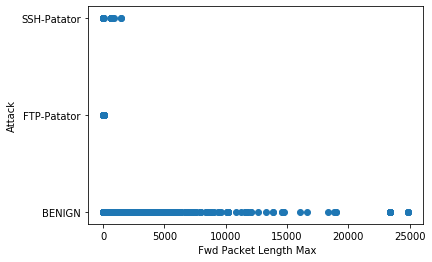

In [58]:
plt.scatter(df[" Fwd Packet Length Max"], df[" Label"])
plt.xlabel(" Fwd Packet Length Max")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

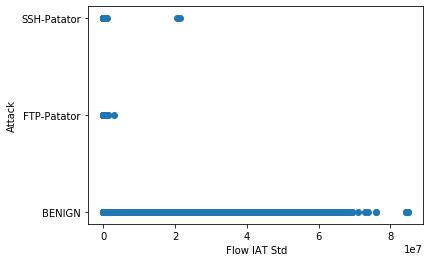

In [59]:
plt.scatter(df[" Flow IAT Std"], df[" Label"])
plt.xlabel(" Flow IAT Std")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

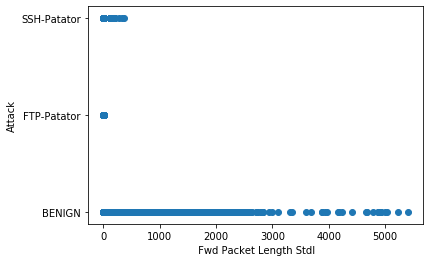

In [81]:

plt.scatter(df[" Fwd Packet Length Std"], df[" Label"])
plt.xlabel(" Fwd Packet Length Stdl")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

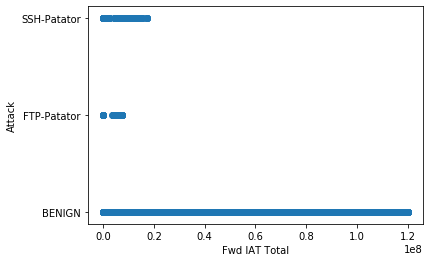

In [23]:
plt.scatter(df["Fwd IAT Total"], df[" Label"])
plt.xlabel("Fwd IAT Total")
plt.ylabel("Attack")


Text(0, 0.5, 'Benign')

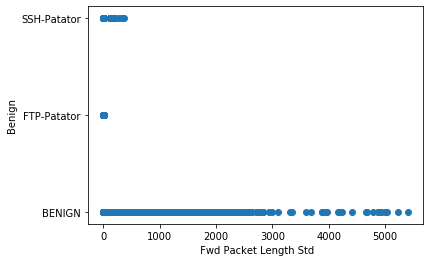

In [24]:
plt.scatter(df[" Fwd Packet Length Std"], df[" Label"])
plt.xlabel(" Fwd Packet Length Std")
plt.ylabel("Benign")


Text(0, 0.5, 'Attack')

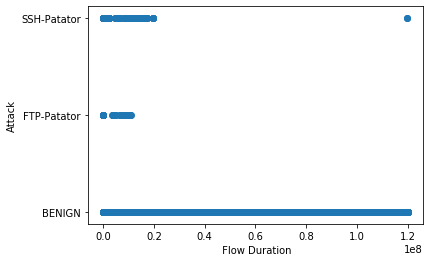

In [25]:
plt.scatter(df[' Flow Duration'], df[" Label"])
plt.xlabel(' Flow Duration')
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

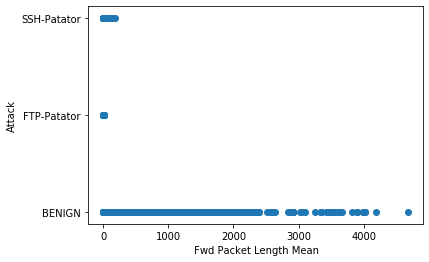

In [36]:
plt.scatter(df[" Fwd Packet Length Mean"], df[" Label"])
plt.xlabel(" Fwd Packet Length Mean")
plt.ylabel("Attack")


Text(0, 0.5, 'Benign')

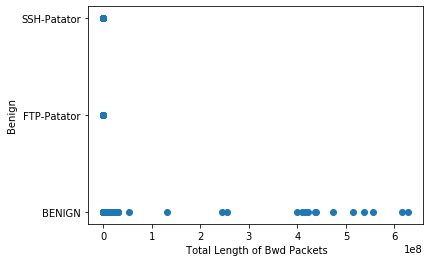

In [38]:
plt.scatter(df[" Total Length of Bwd Packets"], df[" Label"])
plt.xlabel(" Total Length of Bwd Packets")
plt.ylabel("Benign")


Text(0, 0.5, 'Attack')

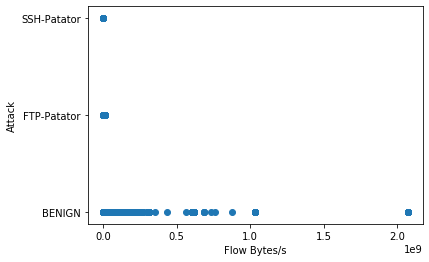

In [63]:
plt.scatter(df["Flow Bytes/s"], df[" Label"])
plt.xlabel("Flow Bytes/s")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

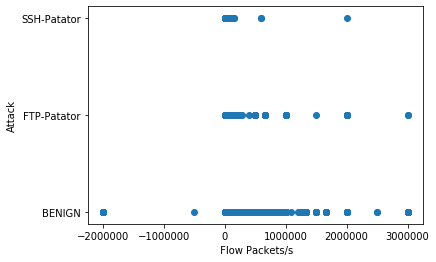

In [64]:
plt.scatter(df[" Flow Packets/s"], df[" Label"])
plt.xlabel(" Flow Packets/s")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

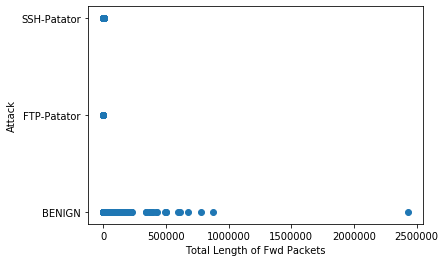

In [65]:
plt.scatter(df["Total Length of Fwd Packets"], df[" Label"])
plt.xlabel("Total Length of Fwd Packets")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

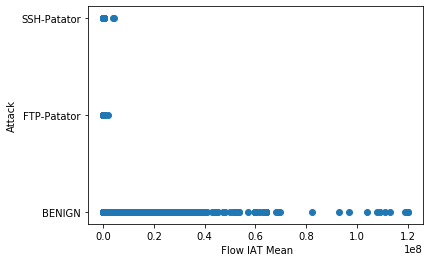

In [66]:
plt.scatter(df[" Flow IAT Mean"], df[" Label"])
plt.xlabel(" Flow IAT Mean")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

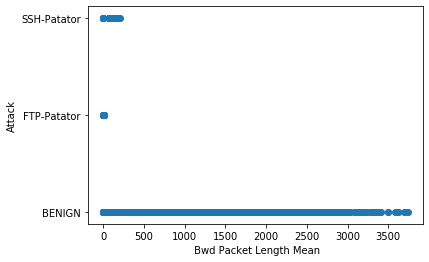

In [67]:
plt.scatter(df[" Bwd Packet Length Mean"], df[" Label"])
plt.xlabel(" Bwd Packet Length Mean")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

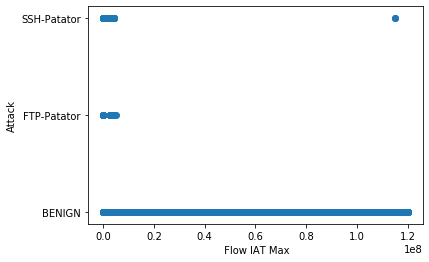

In [68]:
plt.scatter(df[" Flow IAT Max"], df[" Label"])
plt.xlabel(" Flow IAT Max")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

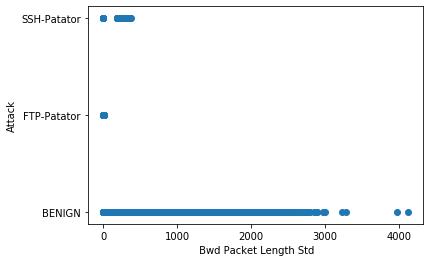

In [69]:
plt.scatter(df[" Bwd Packet Length Std"], df[" Label"])
plt.xlabel(" Bwd Packet Length Std")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

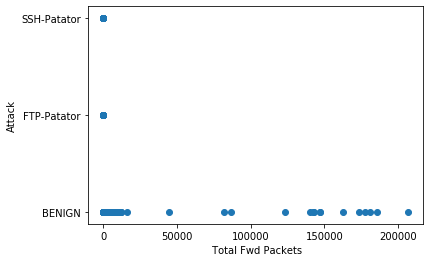

In [70]:
plt.scatter(df[" Total Fwd Packets"], df[" Label"])
plt.xlabel(" Total Fwd Packets")
plt.ylabel("Attack")


Text(0, 0.5, 'Attack')

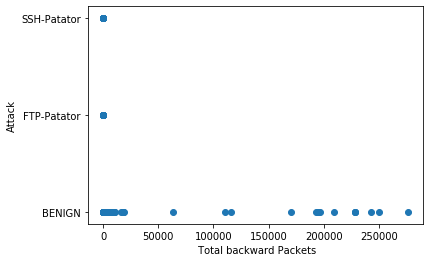

In [71]:
plt.scatter(df[" Total Backward Packets"], df[" Label"])
plt.xlabel(" Total backward Packets")
plt.ylabel("Attack")


### Separating data for Benign, ssh and ftp attacks

In [60]:
df_ftp=df[df[' Label']=='FTP-Patator']
df_ssh=df[df[' Label']=='SSH-Patator']
df_benign=df[df[' Label']=='BENIGN']

In [61]:
df_ftp.head(10)

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
11337                       0   3.010454e+06                0.000000   
11338                       0   0.000000e+00                0.000000   
11339                       0   0.000000e+00                0.000000   
11340                       0   0.000000e+00                0.000000   
11341                       0   0.000000e+00                0.000000   
11342                       0   0.000000e+00                0.000000   
11344                       0   0.000000e+00                0.000000   
11345                      14   7.141778e+01                9.899495   
11346                      22   9.779900e+05                9.633276   
11347                      14   0.000000e+00                9.899495   

       Fwd IAT Total   Flow Packets/s   Flow Duration  \
11337      5216127.0         0.766852         5216127   
11338            0.0    100000.000000              20   
11339            0.0     52631.578950              38   
11340            0.0     25000.000000              80   
11341            0.0     29411.764710              68   
11342            0.0     42553.191490              47   
11344            0.0     24096.385540              83   
11345          265.0     11320.754720             265   
11346      3302859.0         3.633216         3302859   
11347            3.0    666666.666700               3   

        Fwd Packet Length Mean   Total Length of Bwd Packets  Flow Bytes/s  \
11337                      0.0                           0.0  0.000000e+00   
11338                      0.0                           0.0  0.000000e+00   
11339                      0.0                           0.0  0.000000e+00   
11340                      0.0                           0.0  0.000000e+00   
11341                      0.0                           0.0  0.000000e+00   
11342                      0.0                           0.0  0.000000e+00   
11344                      0.0                           0.0  0.000000e+00   
11345                      7.0                           0.0  5.283019e+04   
11346                      6.0                          76.0  3.391002e+01   
11347                      7.0                           0.0  4.666667e+06   

       Total Length of Fwd Packets   Flow IAT Mean   Bwd Packet Length Mean  \
11337                            0    1.738709e+06                 0.000000   
11338                            0    2.000000e+01                 0.000000   
11339                            0    3.800000e+01                 0.000000   
11340                            0    8.000000e+01                 0.000000   
11341                            0    6.800000e+01                 0.000000   
11342                            0    4.700000e+01                 0.000000   
11344                            0    8.300000e+01                 0.000000   
11345                           14    1.325000e+02                 0.000000   
11346                           36    3.002599e+05                12.666667   
11347                           14    3.000000e+00                 0.000000   

        Flow IAT Max   Bwd Packet Length Std   Total Fwd Packets  \
11337      5214882.0                0.000000                   3   
11338           20.0                0.000000                   1   
11339           38.0                0.000000                   1   
11340           80.0                0.000000                   1   
11341           68.0                0.000000                   1   
11342           47.0                0.000000                   1   
11344           83.0                0.000000                   1   
11345          183.0                0.000000                   2   
11346      3248752.0               14.678783                   6   
11347            3.0                0.000000                   2   

        Total Backward Packets        Label  
11337                        1  FTP-Patator  
11338            

In [39]:
df_ssh.head(20)

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
161915                       0         0.0000                0.000000   
161916                     640    534015.4383              166.685104   
161977                     640    504075.2867              155.799100   
161978                     640    511031.6261              159.195034   
161979                     640    523350.2299              166.542430   
161980                       0         0.0000                0.000000   
161981                       0         0.0000                0.000000   
161982                     640    541158.1943              159.195034   
161983                       0         0.0000                0.000000   
161984                       0         0.0000                0.000000   
161987                     640    592238.1453              150.303864   
161988                     640    619891.0069              150.303864   
162065                     640    606268.5598              147.587476   
162068                     640    632948.3739              156.057305   
162069                       0         0.0000                0.000000   
162072                       0         0.0000                0.000000   
162073                       0         0.0000                0.000000   
162075                     640    622987.5004              142.792824   
162076                       0         0.0000                0.000000   
162077                     640    619141.5513              141.914133   

        Fwd IAT Total   Flow Packets/s   Flow Duration  \
161915          404.0      4950.495050             404   
161916      5808851.0         5.680986         5808851   
161977      5840763.0         6.334789         5840763   
161978      5797001.0         6.210108         5797001   
161979      5776990.0         5.885418         5776990   
161980            0.0    100000.000000              20   
161981            0.0     28985.507250              69   
161982      6114814.0         5.887342         6114814   
161983            0.0     23809.523810              84   
161984            0.0     34482.758620              58   
161987      8283147.0         5.070537         8283147   
161988      8589122.0         4.773480         8589122   
162065      8582434.0         5.010234         8582434   
162068      8528425.0         4.572943         8528425   
162069            0.0     19047.619050             105   
162072            0.0     26666.666670              75   
162073            0.0     27027.027030              74   
162075     10500000.0         4.566716        10510835   
162076            0.0     21739.130430              92   
162077      9468779.0         4.442001        11931559   

         Fwd Packet Length Mean   Total Length of Bwd Packets  Flow Bytes/s  \
161915                 0.000000                           0.0      0.000000   
161916                99.733333                        2297.0    652.969064   
161977                82.222222                        2297.0    646.662088   
161978                87.058824                        2297.0    651.543790   
161979                98.666667                        2297.0    653.800682   
161980                 0.000000                           0.0      0.000000   
161981                 0.000000                           0.0      0.000000   
161982                87.058824                        2297.0    617.680276   
161983                 0.000000                           0.0      0.000000   
161984                 0.000000                           0.0      0.000000   
161987                87.157895                        2441.0    494.618772   
161988                87.157895                        2441.0    476.998697   
162065                82.800000                        2441.0    477.370406   
162068                97.411765                        2441.0    480.393508   
162069                 0.000000                           0.0      0.00

In [40]:
df_benign.head(20)

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
0                      220   1.355573e+02              107.349008   
1                      300   1.927952e+02              132.287566   
2                     1388   2.364333e+02              677.274651   
3                      226   9.076765e+01              110.276708   
4                      306   1.486983e+02              134.933317   
5                     1550   1.821085e+02              683.485755   
6                     1537   1.873619e+02              677.753294   
7                     1646   1.016422e+05              562.935859   
8                        0   7.071068e-01                0.000000   
9                     1550   1.678878e+02              683.485755   
10                    1537   4.239486e+02              677.753294   
11                     168   1.978382e+06               85.187971   
12                     968   3.549721e+06              381.791781   
13                       0   3.496188e+01                0.000000   
14                       0   3.008876e+01                0.000000   
15                     227   1.000000e+07              113.500000   
16                    1755   3.665524e+06              490.971796   
17                       0   3.406367e+01                0.000000   
18                     376   2.036932e+04              106.549698   
19                       0   0.000000e+00                0.000000   

    Fwd IAT Total   Flow Packets/s   Flow Duration   Fwd Packet Length Mean  \
0           640.0     1.718750e+04             640                62.857143   
1           900.0     1.444444e+04             900                66.666667   
2          1205.0     9.128631e+03            1205               396.571429   
3           511.0     2.152642e+04             511                64.571429   
4           773.0     1.681759e+04             773                68.000000   
5           986.0     1.521298e+04             986               344.444444   
6           935.0     1.604278e+04             935               341.555556   
7        572849.0     4.713284e+01          572849               271.733333   
8             1.0     3.000000e+06               1                 0.000000   
9          1075.0     1.674419e+04            1075               344.444444   
10         2687.0     5.582434e+03            2687               341.555556   
11     14300000.0     2.313563e+00        14263712                79.238095   
12     14300000.0     1.192314e+00        14257993               216.181818   
13            0.0     5.882353e+04              68                 0.000000   
14            0.0     6.896552e+04              58                 0.000000   
15        75494.0     3.002804e-01        26641766                56.750000   
16     34300000.0     2.131012e+00        34256029               310.102564   
17            0.0     6.451613e+04              62                 0.000000   
18       310531.0     9.016813e+01          310531                62.533333   
19            4.0     5.000000e+05               4                 0.000000   

     Total Length of Bwd Packets  Flow Bytes/s  Total Length of Fwd Packets  \
0                          358.0  1.246875e+06                          440   
1                         2944.0  3.937778e+06                          600   
2                         2830.0  4.652282e+06                         2776   
3                          370.0  1.608611e+06                          452   
4                         2944.0  4.600259e+06                          612   
5                         3030.0  6.217039e+06                         3100   
6                         3010.0  6.506952e+06                         3074   
7                         1020.0  8.895887e+03                         4076   
8                            0.0  0.000000e+00                            0   
9                         3030.0  5.702326e+06                         3100   
10                        

### Standard deviation of features for benign data

In [70]:
ben_std={}

cols = list(df.columns[0:-1])
for col in cols:
    ben_std[col+str('_std')] = df_benign[col].values.std()

# converting to series for further processing
ben_std = pd.Series(ben_std) 
print(ben_std)

 Fwd Packet Length Max_std          4.778144e+02
 Flow IAT Std_std                   5.860450e+06
 Fwd Packet Length Std_std          1.487513e+02
Fwd IAT Total_std                   2.986306e+07
 Flow Packets/s_std                 2.303280e+05
 Flow Duration_std                  2.999846e+07
 Fwd Packet Length Mean_std         1.147536e+02
 Total Length of Bwd Packets_std    2.668090e+06
Flow Bytes/s_std                    2.359402e+07
Total Length of Fwd Packets_std     5.766572e+03
 Flow IAT Mean_std                  4.317292e+06
 Bwd Packet Length Mean_std         3.151428e+02
 Flow IAT Max_std                   1.362517e+07
 Bwd Packet Length Std_std          2.880370e+02
 Total Fwd Packets_std              8.810475e+02
 Total Backward Packets_std         1.191054e+03
dtype: float64


### Standard deviation of features for FTP Attack data

In [72]:
ftp_std={}

cols = list(df.columns[0:-1])
for col in cols:
    ftp_std[col+str('_std')] = df_ftp[col].values.std()
    
# converting to series for further processing
ftp_std = pd.Series(ftp_std) 
print(ftp_std)

 Fwd Packet Length Max_std          5.572105e+00
 Flow IAT Std_std                   5.125854e+05
 Fwd Packet Length Std_std          8.459415e-01
Fwd IAT Total_std                   3.028068e+06
 Flow Packets/s_std                 3.058386e+05
 Flow Duration_std                  4.526970e+06
 Fwd Packet Length Mean_std         2.493508e+00
 Total Length of Bwd Packets_std    9.391640e+01
Flow Bytes/s_std                    2.128678e+06
Total Length of Fwd Packets_std     4.633285e+01
 Flow IAT Mean_std                  1.976268e+05
 Bwd Packet Length Mean_std         6.267051e+00
 Flow IAT Max_std                   1.636901e+06
 Bwd Packet Length Std_std          7.274986e+00
 Total Fwd Packets_std              3.499639e+00
 Total Backward Packets_std         7.186003e+00
dtype: float64


### Standard deviation of features for SSH Attack data

In [75]:
ssh_std={}

cols = list(df.columns[0:-1])
for col in cols:
    ssh_std[col+str('_std')] = df_ssh[col].values.std()
    
# converting to series for further processing
ssh_std = pd.Series(ssh_std) 
print(ssh_std)

 Fwd Packet Length Max_std          3.205947e+02
 Flow IAT Std_std                   4.977605e+05
 Fwd Packet Length Std_std          7.029028e+01
Fwd IAT Total_std                   5.177558e+06
 Flow Packets/s_std                 3.303134e+04
 Flow Duration_std                  6.515325e+06
 Fwd Packet Length Mean_std         4.778573e+01
 Total Length of Bwd Packets_std    1.383771e+03
Flow Bytes/s_std                    8.710135e+03
Total Length of Fwd Packets_std     1.006857e+03
 Flow IAT Mean_std                  1.378822e+05
 Bwd Packet Length Mean_std         4.367718e+01
 Flow IAT Max_std                   2.416856e+06
 Bwd Packet Length Std_std          1.110300e+02
 Total Fwd Packets_std              1.012242e+01
 Total Backward Packets_std         1.552835e+01
dtype: float64


### Dataframe containing standard deviations 

In [76]:
# Converting dataframes containing standard deviations of benign,ftp and ssh attack into single dataframe
frame = { 'benign': ben_std, 'ftp': ftp_std, 'ssh':ssh_std } 
  
df_std_all = pd.DataFrame(frame) 
print(df_std_all)

                                        benign           ftp           ssh
 Fwd Packet Length Max_std        4.778144e+02  5.572105e+00  3.205947e+02
 Flow IAT Std_std                 5.860450e+06  5.125854e+05  4.977605e+05
 Fwd Packet Length Std_std        1.487513e+02  8.459415e-01  7.029028e+01
Fwd IAT Total_std                 2.986306e+07  3.028068e+06  5.177558e+06
 Flow Packets/s_std               2.303280e+05  3.058386e+05  3.303134e+04
 Flow Duration_std                2.999846e+07  4.526970e+06  6.515325e+06
 Fwd Packet Length Mean_std       1.147536e+02  2.493508e+00  4.778573e+01
 Total Length of Bwd Packets_std  2.668090e+06  9.391640e+01  1.383771e+03
Flow Bytes/s_std                  2.359402e+07  2.128678e+06  8.710135e+03
Total Length of Fwd Packets_std   5.766572e+03  4.633285e+01  1.006857e+03
 Flow IAT Mean_std                4.317292e+06  1.976268e+05  1.378822e+05
 Bwd Packet Length Mean_std       3.151428e+02  6.267051e+00  4.367718e+01
 Flow IAT Max_std        

In [81]:
df_std_all['benign'][' Fwd Packet Length Max_std']

477.81442694319674

array(['BENIGN', 'BENIGN', 'BENIGN', ..., 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype=object)

# Don't cross this point

 Separate input features and labels from dataframe


In [4]:
X=df[df.columns[1:-1]]
y=df[df.columns[-1]]
X.dtypes

 Fwd Packet Length Max            int64
 Flow IAT Std                   float64
 Fwd Packet Length Std          float64
Fwd IAT Total                   float64
 Flow Packets/s                  object
 Flow Duration                    int64
 Fwd Packet Length Mean         float64
 Total Length of Bwd Packets    float64
Flow Bytes/s                     object
Total Length of Fwd Packets       int64
 Flow IAT Mean                  float64
 Bwd Packet Length Mean         float64
 Flow IAT Max                   float64
 Bwd Packet Length Std          float64
 Total Fwd Packets                int64
 Total Backward Packets           int64
dtype: object

In [56]:
X.replace("Infinity", 0, inplace=True)
X['Flow Bytes/s'].replace("Infinity", 0,inplace=True)
X[" Flow Packets/s"].replace("Infinity", 0, inplace=True)

In [57]:
X["Flow Bytes/s"]=X["Flow Bytes/s"].astype("float")
X[' Flow Packets/s']=X[" Flow Packets/s"].astype("float")
X.dtypes

/home/ebryx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ebryx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


 Fwd Packet Length Max            int64
 Flow IAT Std                   float64
 Fwd Packet Length Std          float64
Fwd IAT Total                   float64
 Flow Packets/s                 float64
 Flow Duration                    int64
 Fwd Packet Length Mean         float64
 Total Length of Bwd Packets    float64
Flow Bytes/s                    float64
Total Length of Fwd Packets       int64
 Flow IAT Mean                  float64
 Bwd Packet Length Mean         float64
 Flow IAT Max                   float64
 Bwd Packet Length Std          float64
 Total Fwd Packets                int64
 Total Backward Packets           int64
dtype: object

#### Display all rows in column as will be mentioned

In [29]:
pd.set_option('display.max_rows', X.shape[0])
# pd.set_option('display.max_columns', X_train.shape[1])

# X_train.head(3)

### Normalize Data
normalize data using z score so it is easy for our model to learn and outlier could be handled here

In [7]:
from scipy import stats

In [8]:
t1=time.time()

cols = list(X.columns)
for col in cols:
    X[col] = stats.zscore(X[col])
    
t2=time.time()
print("time ::: ", t2-t1 , " seconds to find z score of " , len(cols), "features")

time :::  1.7543418407440186  seconds to find z score of  16 features


/home/ebryx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



##  3. Creation of Training and testing data


In [9]:
from sklearn.model_selection import train_test_split     # import module for train test split

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=10)

In [11]:
X_test.head(1000)

Fwd Packet Length Max   Flow IAT Std   Fwd Packet Length Std  \
282978               -0.267542      -0.252580               -0.340132   
414911               -0.367004      -0.252596               -0.340132   
422681               -0.367004      -0.252596               -0.340132   
189739               -0.248496       2.449914               -0.308173   
130843               -0.276007      -0.252596               -0.340132   
...                        ...            ...                     ...   
298804               -0.318331      -0.252579               -0.340132   
415277               -0.367004      -0.252596               -0.340132   
67766                 0.485830       1.618372                1.058001   
115252               -0.269658      -0.252596               -0.340132   
421018               -0.301401      -0.252580               -0.340132   

        Fwd IAT Total   Flow Packets/s   Flow Duration  \
282978      -0.356875        -0.151739       -0.364797   
414911      -0.356875        -0.256608       -0.363704   
422681      -0.356875        -0.050357       -0.364801   
189739       2.528044        -0.256875        2.507581   
130843      -0.356875        -0.256589       -0.363780   
...               ...              ...             ...   
298804      -0.356875        -0.154227       -0.364797   
415277      -0.356875        -0.178023       -0.364799   
67766        3.550848        -0.256874        3.540732   
115252      -0.356875        -0.256774       -0.361906   
421018      -0.356875        -0.154227       -0.364797   

         Fwd Packet Length Mean   Total Length of Bwd Packets  Flow Bytes/s  \
282978                -0.013694                     -0.008195      0.056352   
414911                -0.428831                     -0.008328     -0.059499   
422681                -0.428831                     -0.008328     -0.059499   
189739                 0.030469                     -0.008162     -0.059498   
130843                -0.049025                     -0.008301     -0.059336   
...                         ...                           ...           ...   
298804                -0.225679                     -0.008311     -0.036062   
415277                -0.428831                     -0.008328     -0.059499   
67766                  1.350957                     -0.007945     -0.059496   
115252                -0.022527                     -0.008299     -0.059436   
421018                -0.155017                     -0.008256      0.004698   

        Total Length of Fwd Packets   Flow IAT Mean   Bwd Packet Length Mean  \
282978                    -0.076865       -0.211028                 0.014617   
414911                    -0.093419       -0.203406                -0.547351   
422681                    -0.093419       -0.211031                -0.547351   
189739                    -0.056788        2.634744                -0.197325   
130843                    -0.085846       -0.203930                -0.319352   
...                             ...             ...                      ...   
298804                    -0.085318       -0.211027                -0.473492   
415277                    -0.093419       -0.211015                -0.547351   
67766                      0.900211        0.451248                -0.316141   
115252                    -0.085318       -0.190903                -0.296874   
421018                    -0.082500       -0.211027                -0.242282   

         Flow IAT Max   Bwd Packet Length Std   Total Fwd Packets  \
282978      -0.296853               -0.446744           -0.011306   
414911      -0.294447               -0.446744           -0.012459   
422681      -0.296862               -0.446744           -0.012459   
189739       2.198604               -0.406637           -0.009000   
130843      -0.294613               -0.446744           -0.012459   
...               ...                     ...                 ...   
298804      -0.296852               -0.446

## 4. Applying ML algorithms

### 1) K-NN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
t1=time.time()

for i in range(1,len(cols)):
    knn=KNeighborsClassifier(n_neighbors=i)
    model_knn=knn.fit(X_train,y_train)
    yhat=model_knn.predict(X_test)
    print("for " , i,  " as K, accuracy is : ", accuracy_score(y_test, yhat))
t2=time.time()
print(" time for ", i ," k's :: ", (t2-t1)/60 , " minutes")

for  1  as K, accuracy is :  0.9874806488523928
for  2  as K, accuracy is :  0.9915415853357564
for  3  as K, accuracy is :  0.9899822754705975
for  4  as K, accuracy is :  0.9920351798254471
for  5  as K, accuracy is :  0.9920127437122793
for  6  as K, accuracy is :  0.9926297368243926
for  7  as K, accuracy is :  0.9926185187678087
for  8  as K, accuracy is :  0.9925960826546409
for  9  as K, accuracy is :  0.9925960826546409
for  10  as K, accuracy is :  0.993044804917996
for  11  as K, accuracy is :  0.9926970451638958
for  12  as K, accuracy is :  0.993044804917996
for  13  as K, accuracy is :  0.993044804917996
for  14  as K, accuracy is :  0.9930111507482444
for  15  as K, accuracy is :  0.9930111507482444
 time for  15  k's ::  56.82399348815282  minutes


### save knn_model for future use

In [11]:
import pickle
filename = 'finalized_model.sav'

In [17]:

pickle.dump(model_knn, open(filename, 'wb'))

In [12]:

# load the model from disk
model_knn = pickle.load(open(filename, 'rb'))
y_hat=model_knn.predict(X_test)


### 2) Naive bayes

#####     2.1) Gaussian naive bayes

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
t1=time.time()

gnb = GaussianNB()
model_gnb = gnb.fit(X_train, y_train)
yhat=model_gnb.predict(X_test)

print("Accuracy :: ", accuracy_score(y_test,yhat))

t2=time.time()
print(" time for Naive Baye's :: ", (t2-t1) , " seconds")

Accuracy ::  0.4973076664198694
 time for Naive Baye's ::  0.8724572658538818  seconds


results for gausian naive bayes are not very good, so we use bernoulli Naive Bayes

##### 2.2) Bernoulli Naive Bayes

In [10]:
from sklearn.naive_bayes import BernoulliNB

In [11]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
yhat=clf.predict(X_test)
print("Accuracy ::: ", accuracy_score(y_test,yhat))

Accuracy :::  0.973188844764533


#### Scatter plot

[]

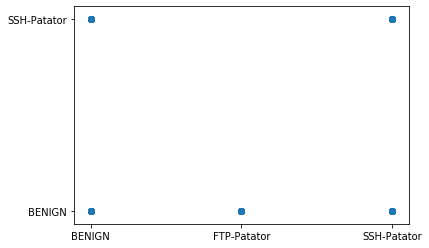

In [15]:
plt.scatter(y_test,yhat)

In [24]:
type(y_test)

pandas.core.series.Series

In [15]:
type(yhat)

numpy.ndarray

In [14]:
y_test_arr=y_test.as_matrix()

/home/ebryx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:

true_benign=0
true_ftp=0
true_ssh=0
false_benign=0
false_ftp=0
false_ssh=0
print(len(y_test_arr))
for x in range(len(y_test_arr)):
    if y_test_arr[x]==yhat[x] and y_test_arr[x]=="BENIGN":
        true_benign=true_benign+1
    elif y_test_arr[x]==yhat[x] and y_test_arr[x]=="FTP-Patator":
        true_ftp=true_ftp+1
    elif y_test_arr[x]==yhat[x] and y_test_arr[x]=="SSH-Patator":
        true_ssh=true_ssh+1
    elif y_test_arr[x]!=yhat[x]:
        if yhat[x]=="BENIGN":
            false_benign=false_benign+1
        elif yhat[x]=="FTP-Patator":
            false_ftp=false_ftp+1
        elif yhat[x]=="SSH-Patator":
            false_ssh=false_ssh+1
print("true benign  ::: ", true_benign )
print("true ftp  ::: ", true_ftp )
print("true ssh  ::: ", true_ssh )
print("false benign  ::: ", false_benign )
print("false ftp ::: ", false_ftp )
print("fasle ssh  ::: ", false_ssh )

89142
true benign  :::  86403
true ftp  :::  1518
true ssh  :::  598
false benign  :::  615
false ftp :::  8
fasle ssh  :::  0


In [15]:
# y_hat= saved model output
true_benign=0
true_ftp=0
true_ssh=0
false_benign=0
false_ftp=0
false_ssh=0

for x in range(len(y_test_arr)):
    
    if y_hat[x]=="BENIGN":
        if y_hat[x]==y_test_arr[x]:
            true_benign=true_benign+1
        else:
            false_benign=false_benign+1
            
    elif y_hat[x]=="FTP-Patator":
        
        if y_hat[x]==y_test_arr[x]:
            true_ftp=true_ftp+1
        else:
            false_ftp=false_ftp+1
            
    elif y_hat[x]=="SSH-Patator":
        if y_hat[x]==y_test_arr[x]:
            true_ssh=true_ssh+1
        else:
            false_ssh=false_ssh+1
            
print("true benign  ::: ", true_benign )
print("true ftp  ::: ", true_ftp )
print("true ssh  ::: ", true_ssh )
print("false benign  ::: ", false_benign )
print("false ftp ::: ", false_ftp )
print("fasle ssh  ::: ", false_ssh )

true benign  :::  86403
true ftp  :::  1518
true ssh  :::  598
false benign  :::  615
false ftp :::  8
fasle ssh  :::  0


## Visualization of results

### 1. Pie Chart

In [19]:
ser={}
ser['true_benign']=true_benign
ser['true ftp']=true_ftp
ser['true ssh']=true_ssh
ser['false benign']=false_benign
ser['false ftp']=false_ftp
ser['false ssh']=false_ssh

In [116]:
series = pd.Series(ser) 


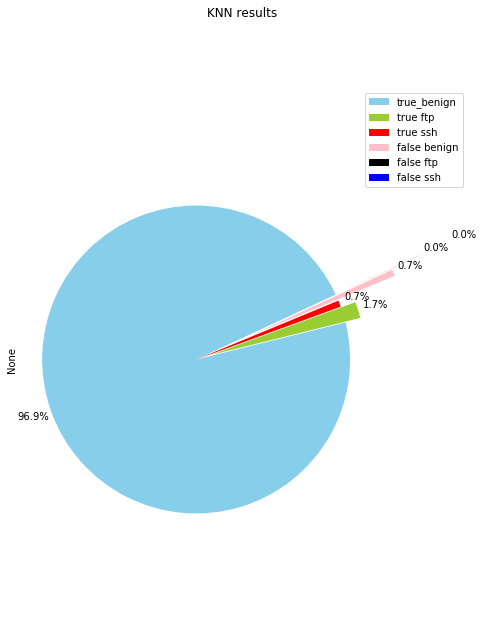

In [121]:
colors_list = ['skyblue', 'yellowgreen', 'red', 'pink', 'black', 'blue']
explode_list = [0, 0.1, 0, 0.4, 0.6, 0.8] # ratio for each continent with which to offset each wedge.

series.plot(kind='pie',
                            figsize=(8, 10),
                            autopct='%1.1f%%',
                            startangle=25,# add in percentages
#                           shadow=False,
                            labels=None,
                            pctdistance=1.12, 
                            explode=explode_list,
                            colors=colors_list,  # add custom colors

           )

plt.title('KNN results ', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=series.index, loc='upper right') 

plt.show()

#### Pie chart with TP,FP,TN,FN

In [123]:
ser3={}
ser3['true positive']=true_ftp+true_ssh
ser3['true negative']=true_benign
ser3['false positive']=false_ftp+false_ssh
ser3['false negative']=false_benign

In [127]:
series3 = pd.Series(ser3) 


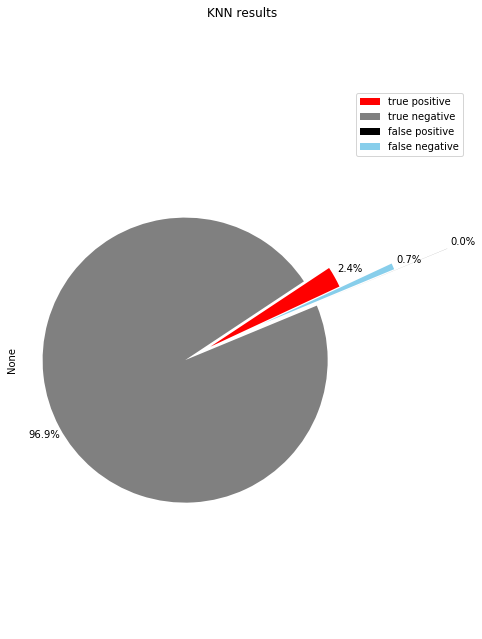

In [136]:
colors_list = ['red', 'gray','black', 'skyblue' ]
explode_list = [0, 0.2, 0.8, 0.4] # ratio for each continent with which to offset each wedge.

series3.plot(kind='pie',
                            figsize=(8, 10),
                            autopct='%1.1f%%',
                            startangle=25,# add in percentages
#                           shadow=False,
                            labels=None,
                            pctdistance=1.12, 
                            explode=explode_list,
                            colors=colors_list,  # add custom colors

           )

plt.title('KNN results ', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=series3.index, loc='upper right') 

plt.show()